In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

3662 images found of 3662 total


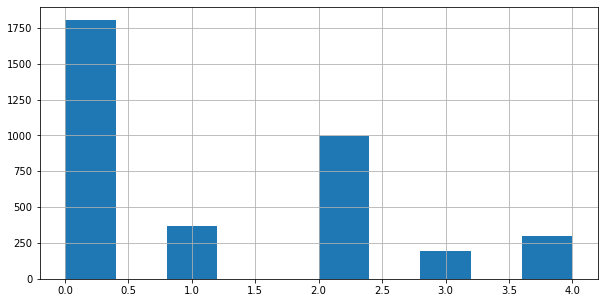

In [23]:
IMG_SIZE = 512  # slightly smaller than vgg16 normally expects
batch_size = 8

config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

base_image_dir = os.path.join('/home/jupyter')

retina_df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df['path'] = retina_df['id_code'].map(lambda x: os.path.join(base_image_dir,'train_images',
                                                         '{}.png'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']].drop_duplicates()
retina_df['level'] = retina_df['diagnosis'].map(lambda x: str(x))
# retina_df
retina_df['diagnosis'].hist(figsize = (10, 5))
plt.show()

New Data Size: 10000 Old Size: 3662
train 8000 validation 2000


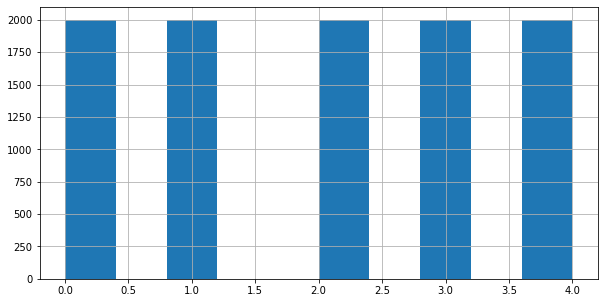

In [24]:
#Split Data into Training and Validation

from sklearn.model_selection import train_test_split
raw_df = retina_df.groupby(['diagnosis']).apply(lambda x: x.sample(n = 2000, replace = True)
                                                      ).reset_index(drop = True)
# raw_df.drop_duplicates()
# a = raw_df.groupby('id_code').count()>1
# price = a[a['diagnosis'] == True].index
# repeat_df = raw_df[raw_df['id_code'].isin(price)]   #show duplicated elements

print('New Data Size:', raw_df.shape[0], 'Old Size:', retina_df.shape[0])

train_df, valid_df = train_test_split(raw_df,
                                   test_size = 0.2,
                                   random_state = 2018)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

raw_df['diagnosis'].hist(figsize = (10, 5))
plt.show()

Found 192 validated image filenames belonging to 5 classes.
Found 49 validated image filenames belonging to 5 classes.
(2, 256, 256, 3)
(2, 5)
float32
float32


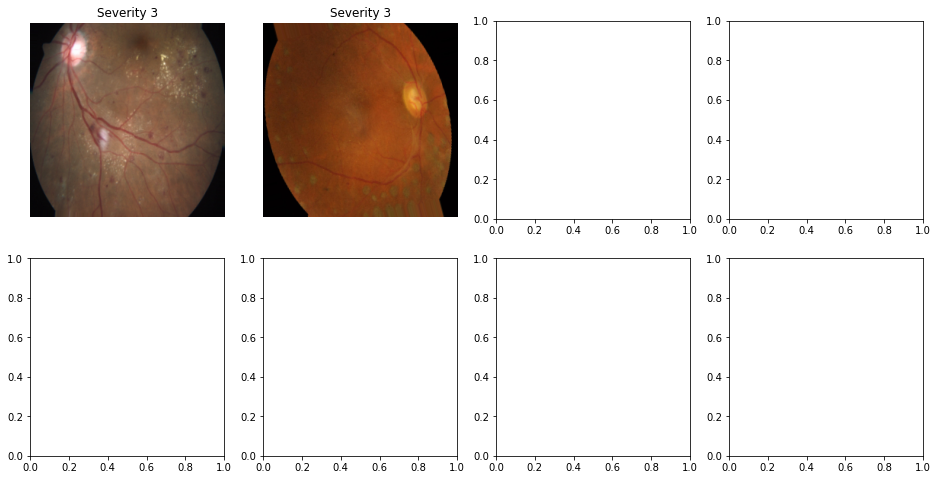

In [50]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, horizontal_flip=True,
    vertical_flip=True, preprocessing_function=preprocess_input,
    data_format="channels_last")
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, horizontal_flip=False,
    vertical_flip=False, preprocessing_function=preprocess_input,
    data_format="channels_last")
valid_generator = valid_datagen.flow_from_dataframe(valid_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
print(train_generator)
t_x, t_y = next(train_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]
print(t_x.shape)
print(t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
    print(c_x.dtype)
plt.show()

In [26]:
# Model Define
# from keras.applications.xception import Xception as PTModel
# from tensorflow.keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
# from tensorflow.keras.applications.inception_v3 import InceptionV3 as PTModel
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB3 as PTModel
# from keras.applications.resnet50 import ResNet50 as PTModel
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = True
# pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)


##################################Comment out for no attention mechanism######################################
# here we do an attention mechanism to turn pixels in the GAP on an off
# attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
# attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
# attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
# attn_layer = Conv2D(1, 
#                     kernel_size = (1,1), 
#                     padding = 'valid', 
#                     activation = 'sigmoid')(attn_layer)

# pt_depth = 1536 # 2048 for Inception, Xception; 1536 for EfficientNet, InceptionResNetV2
# # fan it out to all of the channels
# up_c2_w = np.ones((1, 1, 1, pt_depth))
# up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
#                activation = 'linear', use_bias = False, weights = [up_c2_w])
# up_c2.trainable = False
# attn_layer = up_c2(attn_layer)

# mask_features = multiply([attn_layer, bn_features])
# gap_features = GlobalAveragePooling2D()(mask_features)
# gap_mask = GlobalAveragePooling2D()(attn_layer)
# # to account for missing values from the attention model
# gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
# gap_dr = Dropout(0.25)(gap)

##################################Comment out for attention machanism added####################################
gap_dr = GlobalAveragePooling2D()(pt_features)
gap_dr = Dropout(0.2)(gap_dr)
###############################################################################################################


dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 14, 14, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               196736    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)               

In [21]:
# train
weight_path="{}_weights_best.hdf5".format('inception_resnet_v2_trainable')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='auto', save_weights_only=True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", mode="min", patience=20) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]


# load the best version of the model
# retina_model.load_weights(weight_path)

retina_model.fit(train_generator, steps_per_epoch = train_df.shape[0]//batch_size,
                            validation_data = valid_generator,
                            validation_steps = valid_df.shape[0]//batch_size,
                            epochs=50,
                            verbose=1,
                            callbacks = callbacks_list,
                            workers = 8
                            )



retina_model.save('inception_resnet_v2_trainable_retina_model.h5')

Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 1.0678 - categorical_accuracy: 0.5244 - top_2_accuracy: 0.7646
Epoch 00001: val_loss improved from inf to 0.81304, saving model to inception_resnet_v2_trainable_weights_best.hdf5
1000/1000 [==============================] - 998s 998ms/step - loss: 1.0678 - categorical_accuracy: 0.5244 - top_2_accuracy: 0.7646 - val_loss: 0.8130 - val_categorical_accuracy: 0.6675 - val_top_2_accuracy: 0.8770
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 0.8884 - categorical_accuracy: 0.6089 - top_2_accuracy: 0.8371
Epoch 00002: val_loss improved from 0.81304 to 0.78359, saving model to inception_resnet_v2_trainable_weights_best.hdf5
1000/1000 [==============================] - 991s 991ms/step - loss: 0.8884 - categorical_accuracy: 0.6089 - top_2_accuracy: 0.8371 - val_loss: 0.7836 - val_categorical_accuracy: 0.6635 - val_top_2_accuracy: 0.8695
Epoch 3/50
1000/1000 [==============================] - ETA: 0s 

In [ ]:
# test
model_weights = 'retina_weights_best.hdf5'

batch_size2 = 32

# test_df = pd.read_csv(os.path.join(base_image_dir, 'retinopathy_solution.csv'))

# test_df['path'] = test_df['image'].map(lambda x: os.path.join(base_image_dir, 'diabetic_retinopathy_detection','test',
#                                                                   '{}.jpeg'.format(x)))
# test_df['exists'] = test_df['path'].map(os.path.exists)
# print(test_df['exists'].sum(), 'images found of', test_df.shape[0], 'total')
# test_df['level'] = test_df['level'].map(lambda x: str(0))

# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=0, horizontal_flip=False,
#     vertical_flip=False, preprocessing_function=preprocess_input,
#     data_format="channels_last")

# test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='level',
#                                                     target_size=(IMG_SIZE,IMG_SIZE),
#                                                     batch_size=batch_size,
#                                                     shuffle=False,
#                                                     class_mode='categorical')

retina_model.load_weights(model_weights)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])

retina_model.evaluate(valid_generator,
                            verbose=1,
                            workers = 8
                            )

New Data Size: 241 Old Size: 3662
train 192 validation 49


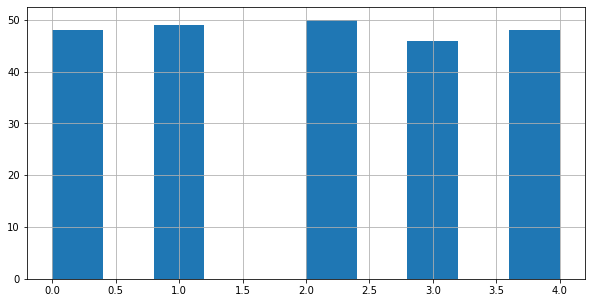

In [41]:

raw_df = retina_df.groupby(['diagnosis']).apply(lambda x: x.sample(n = 50, replace = True)
                                                      ).reset_index(drop = True)

raw_df = raw_df.drop_duplicates()

# a = raw_df.groupby('id_code').count()>1
# price = a[a['diagnosis'] == True].index
# repeat_df = raw_df[raw_df['id_code'].isin(price)]   #show duplicated elements

print('New Data Size:', raw_df.shape[0], 'Old Size:', retina_df.shape[0])

train_df, valid_df = train_test_split(raw_df,
                                   test_size = 0.2,
                                   random_state = 2020)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

raw_df['diagnosis'].hist(figsize = (10, 5))
plt.show()

Found 192 validated image filenames belonging to 5 classes.
Found 49 validated image filenames belonging to 5 classes.
(2, 256, 256, 3)
(2, 5)
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]


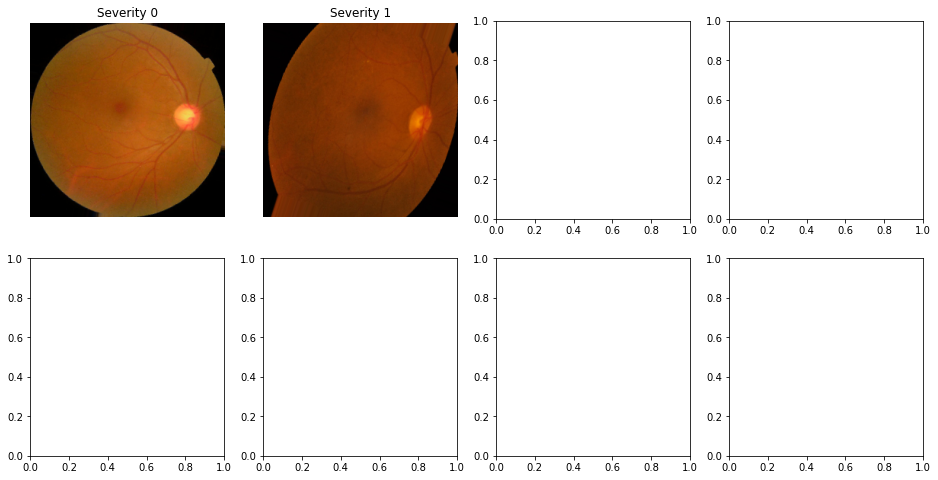

In [47]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, horizontal_flip=True,
    vertical_flip=True, preprocessing_function=preprocess_input,
    data_format="channels_last")
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, horizontal_flip=False,
    vertical_flip=False, preprocessing_function=preprocess_input,
    data_format="channels_last")
valid_generator = valid_datagen.flow_from_dataframe(valid_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
print(train_generator)
t_x, t_y = next(train_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]
print(t_x.shape)
print(t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
    print(c_y)
plt.show()

In [3]:
import ResidualAttentionNetwork as RAN
from tensorflow.keras import optimizers

epochs = 50
batch_size = 2
IMG_SIZE = 256

weight_path="{}_weights_best.hdf5".format('residual_attention_pretrain')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='auto', save_weights_only=True)

model = RAN.ResidualAttentionNetwork((IMG_SIZE, IMG_SIZE, 3), 5, activation='softmax').build_model()
model.summary()
# model.compile(optimizer=optimizers.Adam(lr=0.01),
#               loss='categorical_crossentropy',
#               metrics=['categorical_accuracy', top_2_accuracy])

# model.fit(train_generator,
#           steps_per_epoch=train_df.shape[0]//batch_size,
#           verbose=1,
#           validation_data=valid_generator,
#           validation_steps=valid_df.shape[0]//batch_size,
#           epochs=epochs)

# model.save('residual_attention_model.h5')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         max_pooling2d[0][0]              
_______________________________________________________________________________________